In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/us-accidents/US_Accidents_Dec20_Updated.csv


In [2]:
def get_dataset():
    
    file_name = "Us_Econ.csv"
    
    df=pd.read_csv("/kaggle/input/us-accidents/US_Accidents_Dec20_Updated.csv")

    df['year'] = df["Start_Time"].apply(lambda x : x.split("-")[0] )

    year_2016 = df[df['year'] == "2016"].sample(40000)
    year_2017 = df[df['year'] == "2017"].sample(40000)
    year_2018 = df[df['year'] == "2018"].sample(40000)
    year_2019 = df[df['year'] == "2019"].sample(40000)
    year_2020 = df[df['year'] == "2020"].sample(40000)

    pd.concat([year_2016, year_2017, year_2018, year_2019, year_2020]).to_csv(file_name)
    
get_dataset()

In [3]:
!pip install pyspark

     |████████████████████████████████| 212.4 MB 49 kB/s s eta 0:00:01
     |████████████████████████████████| 198 kB 53.2 MB/s eta 0:00:01
  Created wheel for pyspark: filename=pyspark-3.1.2-py2.py3-none-any.whl size=212880768 sha256=b9e5d8fb4de382060721ef3d5bd3aa9feb643feae0a8e014c570a7ee42a759af
  Stored in directory: /root/.cache/pip/wheels/a5/0a/c1/9561f6fecb759579a7d863dcd846daaa95f598744e71b02c77
Successfully built pyspark


In [4]:
import os
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 400)

from matplotlib import rcParams
sns.set(context='notebook', style='whitegrid', rc={'figure.figsize': (18,4)})
rcParams['figure.figsize'] = 18,4

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Create Spark context

In [6]:
# Create SparkSession
spark = SparkSession.builder.appName('US_Economy_2016-2020').getOrCreate()

In [7]:
sqlContext = SQLContext(spark.sparkContext)
sqlContext

# Load Files

In [8]:
os.listdir("../working")

['Us_Econ.csv', '__notebook_source__.ipynb']

In [10]:
DATA_PATH = "../working/"
acc_df = spark.read.option("header","true").csv(DATA_PATH+"Us_Econ.csv")

In [11]:
acc_df.show(10)

+-------+---------+--------+-------------------+-------------------+------------------+------------------+---------+----------+------------------+--------------------+------+--------------------+----+------------+--------------------+-----+----------+-------+----------+------------+-------------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+----+
|    _c0|       ID|Severity|         Start_Time|           End_Time|         Start_Lat|         Start_Lng|  End_Lat|   End_Lng|      Distance(mi)|         Description|Number|              Street|Side|        City|              County|State|   Zipcode|Country|  Timezone|Airport_Code|  Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Vi

In [12]:
acc_df.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- ID: string (nullable = true)
 |-- Severity: string (nullable = true)
 |-- Start_Time: string (nullable = true)
 |-- End_Time: string (nullable = true)
 |-- Start_Lat: string (nullable = true)
 |-- Start_Lng: string (nullable = true)
 |-- End_Lat: string (nullable = true)
 |-- End_Lng: string (nullable = true)
 |-- Distance(mi): string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Number: string (nullable = true)
 |-- Street: string (nullable = true)
 |-- Side: string (nullable = true)
 |-- City: string (nullable = true)
 |-- County: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Zipcode: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Timezone: string (nullable = true)
 |-- Airport_Code: string (nullable = true)
 |-- Weather_Timestamp: string (nullable = true)
 |-- Temperature(F): string (nullable = true)
 |-- Wind_Chill(F): string (nullable = true)
 |-- Humidity(%): string (nullab

# Removing Duplicates

In [13]:
acc_df = acc_df.dropDuplicates()

## DataFrame shape

In [14]:
print((acc_df.count(), len(acc_df.columns)))

(20000, 49)


No duplicates

## Check some samples

In [15]:
acc_df.take(5)

[Row(_c0='2037597', ID='A-2037598', Severity='2', Start_Time='2016-07-29 08:37:27', End_Time='2016-07-29 14:37:27', Start_Lat='32.765972', Start_Lng='-96.920115', End_Lat='32.766061', End_Lng='-96.917464', Distance(mi)='0.154', Description='At TX-12-LOOP/Exit 38 - Accident.', Number=None, Street='Tom Landry Fwy', Side='R', City='Dallas', County='Dallas', State='TX', Zipcode='75212', Country='US', Timezone='US/Central', Airport_Code='KDAL', Weather_Timestamp='2016-07-29 08:53:00', Temperature(F)='82.0', Wind_Chill(F)=None, Humidity(%)='69.0', Pressure(in)='30.01', Visibility(mi)='10.0', Wind_Direction='SW', Wind_Speed(mph)='8.1', Precipitation(in)=None, Weather_Condition='Mostly Cloudy', Amenity='False', Bump='False', Crossing='False', Give_Way='False', Junction='False', No_Exit='False', Railway='False', Roundabout='False', Station='False', Stop='False', Traffic_Calming='False', Traffic_Signal='False', Turning_Loop='False', Sunrise_Sunset='Day', Civil_Twilight='Day', Nautical_Twilight='

# Dropping Features

In [16]:
col = (
    "_c0",
    "Description",
    "ID",
    "Zipcode",   
    "End_Lat",
    "End_Lng",
    "Airport_Code",
    "Zipcode",
    "Weather_Timestamp",
    "Start_Time",
    "End_Time", 
    "Timezone",
    "Street"
)
acc_df = acc_df.drop(*col) 

In [17]:
from pyspark.sql.functions import when, count, col

acc_df.select([count(when(F.isnull(c), c)).alias(c) for c in acc_df.columns]).toPandas().T

,0
Severity,0
Start_Lat,0
Start_Lng,0
Distance(mi),0
Number,13387
Side,0
City,0
County,0
State,0
Country,0


In [18]:
#Drop column with more than 1/2 of missing values
col = (
   "Precipitation(in)",
    "Wind_Chill(F)",
    "Number"
)
acc_df = acc_df.drop(*col) 

In [19]:
missing_col =[]
for col in acc_df.columns:
    df_filter = acc_df.filter(acc_df[col].isNull()).count()
    if(df_filter > 0):
        missing_col.append(col)
        
print(missing_col)

['Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)', 'Weather_Condition']


In [20]:
acc_df = acc_df.na.drop()

In [21]:
acc_df.count()

17182

# Pre-Processing and Modelling

In [22]:
from pyspark.ml.classification import LinearSVC, DecisionTreeClassifier,  LogisticRegression, RandomForestClassifier
from pyspark.ml.feature import VectorAssembler, StandardScaler

### Encode String Values

In [23]:
cat_variables = list(set([item[0] for item in acc_df.dtypes if item[1].startswith('string')]))

In [24]:
output = [col+"_Encode" for col in cat_variables]

In [25]:
from pyspark.ml.feature import StringIndexer
indexer = StringIndexer(inputCols=cat_variables, outputCols = output) 
indexer = indexer.fit(acc_df)
acc_df = indexer.transform(acc_df)

### Train-test split

In [26]:
train, test = acc_df.randomSplit([.8,.2], seed= 2021)

In [27]:
train = train.select([column for column in train.columns if column not in cat_variables])
test = test.select([column for column in test.columns if column not in cat_variables])

In [28]:
columnList = list(set([item[0] for item in train.dtypes if item[1].startswith('string') == False]))
columnList.extend(output)
columnList = list(set(columnList))

columnList.remove("Severity_Encode")
columnList 

['County_Encode',
 'Traffic_Signal_Encode',
 'year_Encode',
 'Wind_Direction_Encode',
 'Weather_Condition_Encode',
 'Civil_Twilight_Encode',
 'Stop_Encode',
 'Side_Encode',
 'Crossing_Encode',
 'Roundabout_Encode',
 'Start_Lng_Encode',
 'No_Exit_Encode',
 'Astronomical_Twilight_Encode',
 'Visibility(mi)_Encode',
 'Pressure(in)_Encode',
 'Temperature(F)_Encode',
 'Start_Lat_Encode',
 'Junction_Encode',
 'City_Encode',
 'Traffic_Calming_Encode',
 'Sunrise_Sunset_Encode',
 'State_Encode',
 'Amenity_Encode',
 'Turning_Loop_Encode',
 'Wind_Speed(mph)_Encode',
 'Country_Encode',
 'Give_Way_Encode',
 'Station_Encode',
 'Nautical_Twilight_Encode',
 'Bump_Encode',
 'Distance(mi)_Encode',
 'Railway_Encode',
 'Humidity(%)_Encode']

## Vector Assembler

In [29]:
assembler = VectorAssembler(inputCols=columnList , outputCol="features") 
train = assembler.transform(train)
test = assembler.transform(test)

## Standard Scaler

In [30]:
standardScaler = StandardScaler(inputCol="features", outputCol="features_scaled")
scaler = standardScaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

## PCA-Dimension Reduction

In [31]:
from pyspark.ml.feature import PCA as PCAml

pca = PCAml(k=3, inputCol="features_scaled", outputCol="pca")
model = pca.fit(train)
train = model.transform(train)
test = model.transform(test)

In [32]:
results = {}

## Logistic Regression

In [33]:
train.take(1)

[Row(Civil_Twilight_Encode=0.0, No_Exit_Encode=0.0, year_Encode=2.0, Bump_Encode=0.0, Traffic_Calming_Encode=0.0, Junction_Encode=0.0, Pressure(in)_Encode=14.0, Start_Lat_Encode=57.0, Traffic_Signal_Encode=0.0, Weather_Condition_Encode=4.0, Astronomical_Twilight_Encode=0.0, Railway_Encode=0.0, Country_Encode=0.0, Temperature(F)_Encode=71.0, Crossing_Encode=0.0, Turning_Loop_Encode=0.0, Wind_Speed(mph)_Encode=14.0, Nautical_Twilight_Encode=0.0, State_Encode=1.0, Side_Encode=0.0, Give_Way_Encode=0.0, City_Encode=4.0, Amenity_Encode=0.0, Start_Lng_Encode=381.0, Roundabout_Encode=0.0, Humidity(%)_Encode=13.0, Severity_Encode=0.0, Station_Encode=0.0, Distance(mi)_Encode=341.0, County_Encode=4.0, Stop_Encode=0.0, Sunrise_Sunset_Encode=0.0, Wind_Direction_Encode=15.0, Visibility(mi)_Encode=0.0, features=SparseVector(33, {0: 4.0, 2: 2.0, 3: 15.0, 4: 4.0, 10: 381.0, 14: 14.0, 15: 71.0, 16: 57.0, 18: 4.0, 21: 1.0, 24: 14.0, 30: 341.0, 32: 13.0}), features_scaled=SparseVector(33, {0: 0.0338, 2: 1

In [50]:
lr = LogisticRegression(labelCol="Severity_Encode", featuresCol="pca")
lr_model = lr.fit(train)
lr_prediction =lr_model.transform(test)
lr_prediction

DataFrame[Civil_Twilight_Encode: double, No_Exit_Encode: double, year_Encode: double, Bump_Encode: double, Traffic_Calming_Encode: double, Junction_Encode: double, Pressure(in)_Encode: double, Start_Lat_Encode: double, Traffic_Signal_Encode: double, Weather_Condition_Encode: double, Astronomical_Twilight_Encode: double, Railway_Encode: double, Country_Encode: double, Temperature(F)_Encode: double, Crossing_Encode: double, Turning_Loop_Encode: double, Wind_Speed(mph)_Encode: double, Nautical_Twilight_Encode: double, State_Encode: double, Side_Encode: double, Give_Way_Encode: double, City_Encode: double, Amenity_Encode: double, Start_Lng_Encode: double, Roundabout_Encode: double, Humidity(%)_Encode: double, Severity_Encode: double, Station_Encode: double, Distance(mi)_Encode: double, County_Encode: double, Stop_Encode: double, Sunrise_Sunset_Encode: double, Wind_Direction_Encode: double, Visibility(mi)_Encode: double, features: vector, features_scaled: vector, pca: vector, rawPrediction:

In [51]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics
# Make prediction
predictionAndTarget = lr_prediction.select("Severity_Encode","prediction")

# Create both evaluators
metrics_multi = MulticlassMetrics(predictionAndTarget.rdd.map(tuple))
metrics_binary = BinaryClassificationMetrics(predictionAndTarget.rdd.map(tuple))

acc = metrics_multi.accuracy
auc = metrics_binary.areaUnderROC

results['logistic_regression'] = {}
results['logistic_regression']['roc_auc'] = auc
results['logistic_regression']['accuracy'] = acc


## Decision Tree

In [57]:
tree = DecisionTreeClassifier(labelCol="Severity_Encode", featuresCol="pca")
tree_model = tree.fit(train)
tree_prediction = tree_model.transform(test )

In [58]:
# Make prediction
predictionAndTarget = tree_prediction.select("Severity_Encode","prediction")

# Create both evaluators
metrics_multi = MulticlassMetrics(predictionAndTarget.rdd.map(tuple))
metrics_binary = BinaryClassificationMetrics(predictionAndTarget.rdd.map(tuple))

acc = metrics_multi.accuracy
auc = metrics_binary.areaUnderROC

results['decision_tree'] = {}
results['decision_tree']['roc_auc'] = auc
results['decision_tree']['accuracy'] = acc

## Model Evaluation

In [67]:
metric_df = pd.DataFrame(results).T

In [64]:
metric_df

,roc_auc,accuracy
logistic_regression,0.677264,0.704585
decision_tree,0.659565,0.703725


<AxesSubplot:>

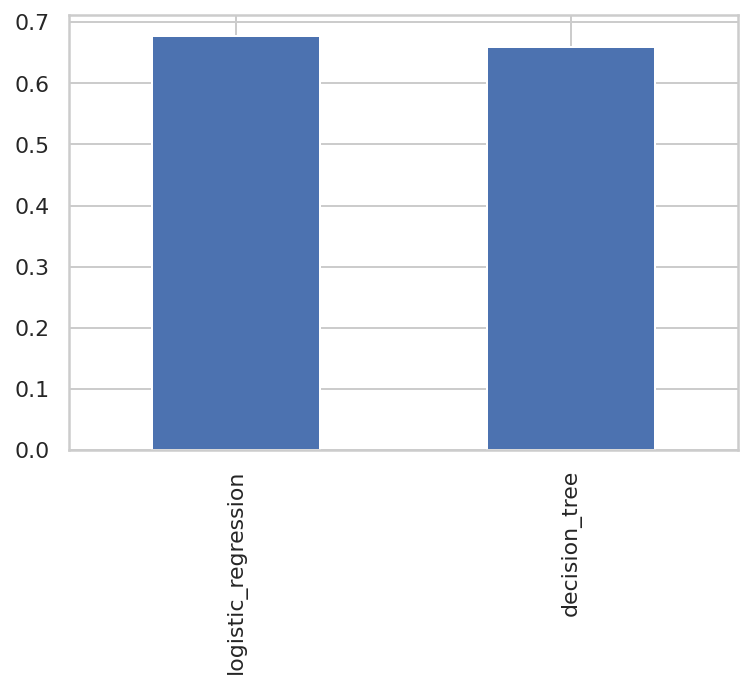

In [65]:
metric_df['roc_auc'].plot(kind="bar")

<AxesSubplot:>

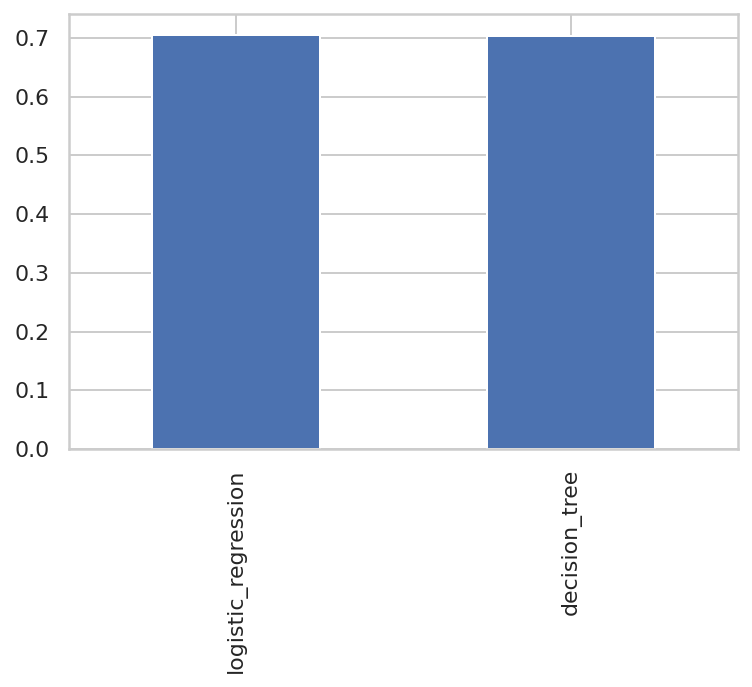

In [66]:
metric_df['accuracy'].plot(kind="bar")